In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc 
plt.style.use('ggplot') # Lets make our plots pretty

path = os.getcwd()

print(path)  

/Users/owner/Desktop/kagle_elo/Models


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Read in the dataframes
train = pd.read_csv('../input/train_1.csv')
test = pd.read_csv('../input/test_1.csv')
merchants = pd.read_csv('../input/merchants.csv')
#new_merchants = pd.read_csv('../input/new_merchant_transactions.csv')
new_merchants = pd.read_csv('../input/nmt_replace.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [3]:
target = train['target']
del train['target']
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.7 ,
         "bagging_seed": 2015,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

In [4]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
#start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72315	valid_1's rmse: 3.79308
[200]	training's rmse: 3.65253	valid_1's rmse: 3.75117
[300]	training's rmse: 3.60399	valid_1's rmse: 3.7281
[400]	training's rmse: 3.56826	valid_1's rmse: 3.71528
[500]	training's rmse: 3.54044	valid_1's rmse: 3.70673
[600]	training's rmse: 3.51661	valid_1's rmse: 3.70123
[700]	training's rmse: 3.49579	valid_1's rmse: 3.69701
[800]	training's rmse: 3.47647	valid_1's rmse: 3.69375
[900]	training's rmse: 3.45983	valid_1's rmse: 3.69149
[1000]	training's rmse: 3.44468	valid_1's rmse: 3.68925
[1100]	training's rmse: 3.43045	valid_1's rmse: 3.68802
[1200]	training's rmse: 3.41667	valid_1's rmse: 3.68656
[1300]	training's rmse: 3.40323	valid_1's rmse: 3.68534
[1400]	training's rmse: 3.39063	valid_1's rmse: 3.68444
[1500]	training's rmse: 3.37847	valid_1's rmse: 3.68368
[1600]	training's rmse: 3.36637	valid_1's rmse: 3.68297
[1700]	training's rmse: 3.35503	valid_1's rmse: 3.6

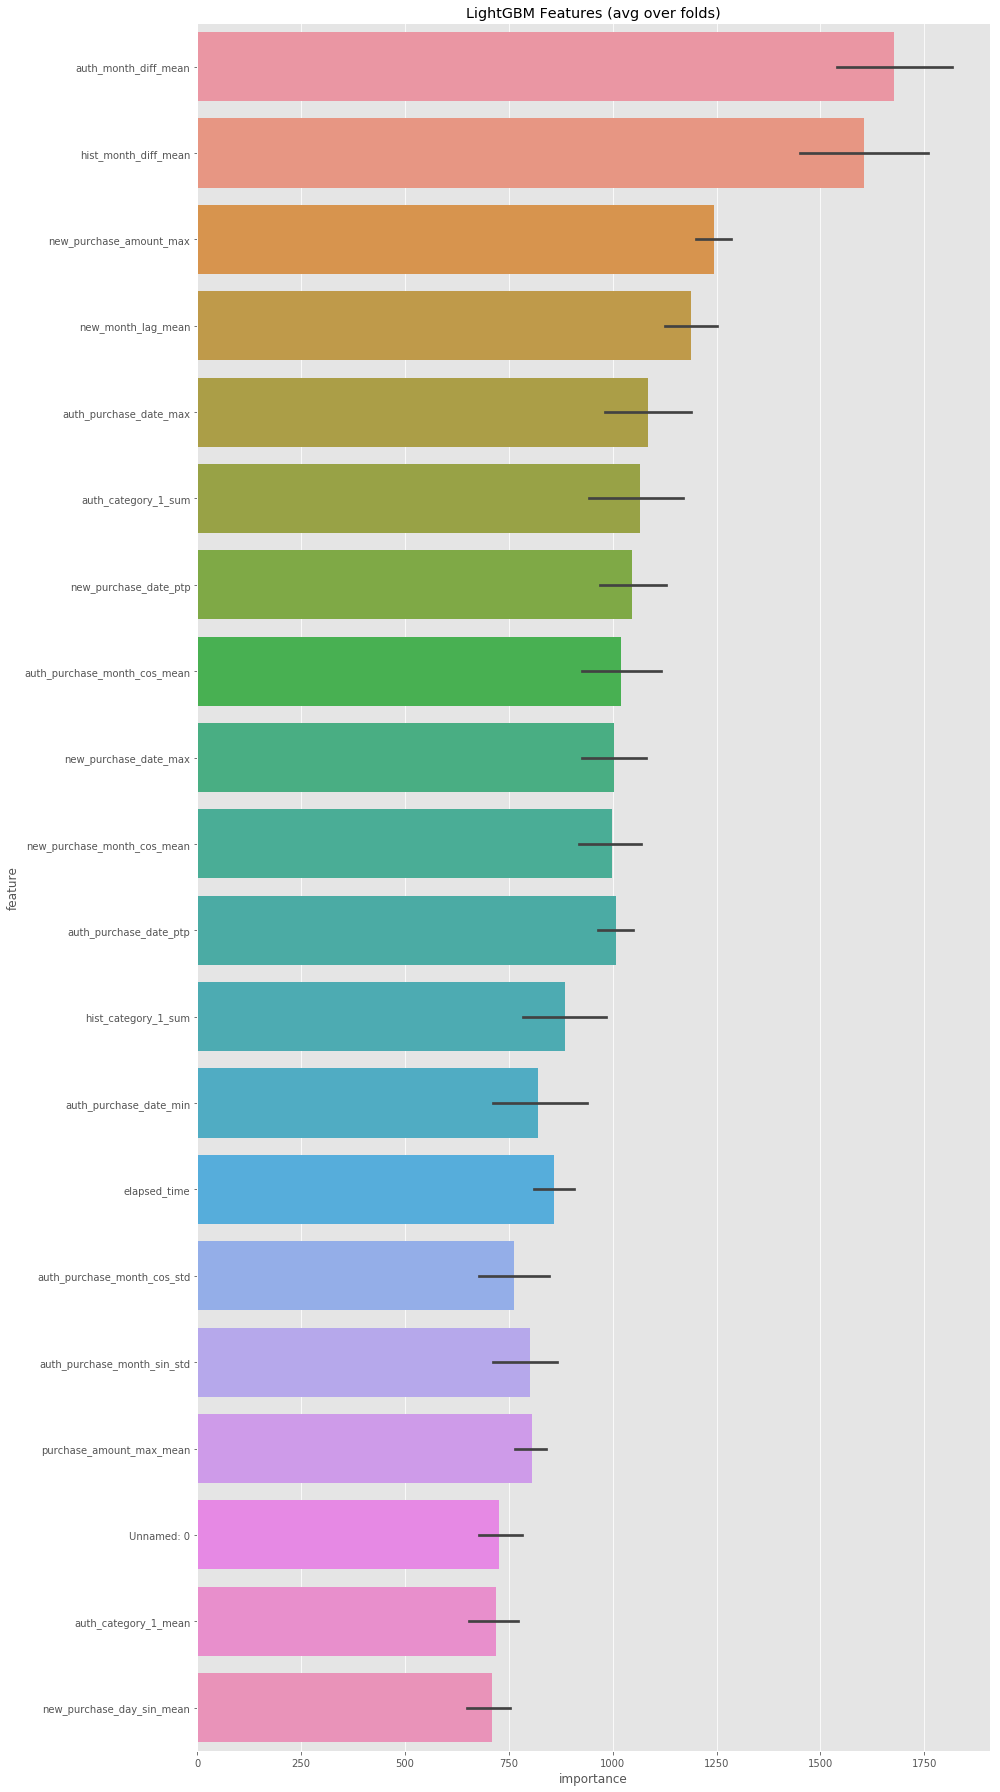

In [5]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [6]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'dart',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [9]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.75676	valid_1's rmse: 3.7964
[200]	training's rmse: 3.69763	valid_1's rmse: 3.76081
[300]	training's rmse: 3.66635	valid_1's rmse: 3.74534
[400]	training's rmse: 3.64583	valid_1's rmse: 3.73723
[500]	training's rmse: 3.61523	valid_1's rmse: 3.7246
[600]	training's rmse: 3.59977	valid_1's rmse: 3.72027
[700]	training's rmse: 3.57739	valid_1's rmse: 3.71336
[800]	training's rmse: 3.55613	valid_1's rmse: 3.70823
[900]	training's rmse: 3.54012	valid_1's rmse: 3.70505
[1000]	training's rmse: 3.5239	valid_1's rmse: 3.70244
[1100]	training's rmse: 3.50593	valid_1's rmse: 3.70123
[1200]	training's rmse: 3.48901	valid_1's rmse: 3.69765
[1300]	training's rmse: 3.4707	valid_1's rmse: 3.69536
[1400]	training's rmse: 3.45514	valid_1's rmse: 3.69299
[1500]	training's rmse: 3.44805	valid_1's rmse: 3.69342
Early stopping, best iteration is:
[1402]	training's rmse: 3.45494	valid_1's rmse: 3.69288
fold n°1
T

[1300]	training's rmse: 3.46307	valid_1's rmse: 3.7289
[1400]	training's rmse: 3.44727	valid_1's rmse: 3.72743
[1500]	training's rmse: 3.43994	valid_1's rmse: 3.72647
[1600]	training's rmse: 3.42859	valid_1's rmse: 3.72578
[1700]	training's rmse: 3.41147	valid_1's rmse: 3.72356
[1800]	training's rmse: 3.39619	valid_1's rmse: 3.72186
[1900]	training's rmse: 3.37951	valid_1's rmse: 3.72012
[2000]	training's rmse: 3.36687	valid_1's rmse: 3.71859
[2100]	training's rmse: 3.35727	valid_1's rmse: 3.7178
[2200]	training's rmse: 3.34665	valid_1's rmse: 3.71755
[2300]	training's rmse: 3.33165	valid_1's rmse: 3.7165
Early stopping, best iteration is:
[2284]	training's rmse: 3.33219	valid_1's rmse: 3.71638
fold n°6
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.76134	valid_1's rmse: 3.77587
[200]	training's rmse: 3.70212	valid_1's rmse: 3.74372
[300]	training's rmse: 3.671	valid_1's rmse: 3.72925
[400]	training's rmse: 3.64973	valid_1's rmse: 3.72056
[500]	

KeyboardInterrupt: 

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
sub_df = pd.read_csv("../input//sample_submission.csv")
sub_df["target"] = predictions
sub_df.to_csv("submit_lgb3.csv", index=False)

In [ ]:
n=5
sub_df = pd.read_csv("../input/sample_submission.csv")
sub_df["target"] = predictions
sub_df.to_csv("submit_lgb",str(n),".csv", index=False)

sub_df1 = pd.read_csv("../input/sample_submission.csv")
sub_df1["target"] = predictions_lgb
sub_df1.to_csv("submit_lgb",str(n),".csv", index=False)

In [ ]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
    
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('Bayesian_Ridge_Stacking.csv', index=False)

In [ ]:
sample_submission['target'] = predictions * 0.5 + predictions_lgb * 0.5
sample_submission.to_csv("../output/submit.csv", index = False)